In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import random, math
from collections import defaultdict
from IPython.display import clear_output

%matplotlib inline

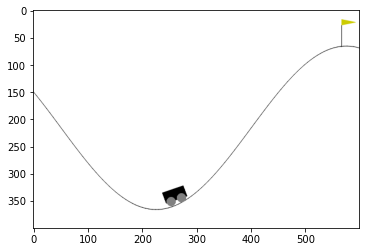

In [2]:
# Создаем окружение
env = gym.make('MountainCar-v0')
env.reset()

# Отрисовываем изображение начального положения
plt.imshow(env.render('rgb_array'))
env.close()

### Интерфейс среды в OpenAI gym

Основные методы класса Env:
\begin{itemize}
    \item reset() - инициализация окружения, возвращает первое наблюдение
    \item render() - визуализация текущего состояния среды
    \item step($a$) - выполнить в среде действие a и получить: new observation - новое наблюдение после выполнения действия $a$; reward - вознаграждение за выполненное действие $a$; $is\_done$ - True, если процесс завершился, False иначе; $info$ - дополнительная информация
\end{itemize}

In [3]:
# Начальное состояние среды
obs0 = env.reset()
print("Изначальное состояние среды:", obs0)

# Если делаем движение вправо, то получаем новое состояние среды:
new_obs, reward, is_done, _ = env.step(2)
print("\nНовое состояние:", new_obs, 
      "\n\nВознаграждение", reward) 

Изначальное состояние среды: [-0.57013756  0.        ]

Новое состояние: [-0.56878966  0.00134791] 

Вознаграждение -1.0


In [4]:
# Функция выбора действия в зависимости от состояния (необходимо раскачать тележку)
def act(s):
    actions = {'left': 0, 'stop': 1, 'right': 2}
    
    # В зависимости от полученного состояния среды выбираем действия так, чтобы тележка достигла флага.
    
    # Захардкоженая стратегия: если наша координата меньше 0 (т.е. тележка слевой стороны, то движемся влево), 
    # если справа то "давим на газ" вправо.
    
    action = actions['left'] if s[1] < 0 else actions["right"]
    return action

# создаем окружение, с ограничением на число шагов в 249
env = gym.wrappers.TimeLimit(
    gym.make("MountainCar-v0").unwrapped,
    max_episode_steps=250)
# проводим инициализацию и запоминаем начальное состояние
s = env.reset()
done = False
while not done:
    # выполняем действие, получаем s, r, done (выполняем act в зивисмости от соятония s)
    s, r, done, _ = env.step(act(s))
    # визуализируем окружение
    env.render()

# Окружение необходимо закрывать    
env.close()
# Если мы смогли подняться выше нужной координаты
if s[0] > 0.47:
    print("Финиш")
else:
    raise NotImplementedError("""
    Некорректная функция выбора действия!""")

Финиш


## Q-learning

Агент, который принимает решения на основе $Q$-функции, не требует модель для обучения и выбора действий, т.е. такой агент также свободен от модели (model-free), как и TD-агент. Уравнение Беллмана для значения Q-функции:

$$Q(s,a)=r(s)+\gamma\sum_s'T(s,a,s')\max_{a'}Q(a',s')$$

Уравнение для итерационного обновления значений Q-функции выглядит следующим образом:
$$Q(s,a)\leftarrow Q(s,a)+\alpha(r(s)+\gamma\max_{a'}Q(a',s') - Q(s,a)).$$

Алгоритм в виде класса **QLearningAgent**:

In [147]:
class QLearningAgent():
    """
    Q-Learning агент
    
    """
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        # get_legal_actions - те действия (a), которые мы сможем получать от пространства действий (A)
        self.get_legal_actions = get_legal_actions
        # Инициализаций матрицы Q
        self._q_values = defaultdict(lambda: defaultdict(lambda: 0))  
        self.alpha = alpha
        self.epsilon = epsilon
        # discount - штраф за действие (гамма из формулы, которая говорит о том, что чем "дальше" действие тем оно менее значимо)
        self.discount = discount

    # Получение Q-value для состояния и действия
    def get_q_value(self, state, action):
        return self._q_values[state][action]
    
    # Установление значение
    def set_q_value(self, state, action, value):
        self._q_values[state][action] = value

Добавим агенту возможность вычислять оценки $V$:

In [148]:
def get_value(self, state):
    """
    Возвращает значение функции полезности, рассчитанной по Q[state, action]
    """
    
    # Берем возможные возможные действия для текущего состояния
    possible_actions = self.get_legal_actions(state)
    
    # Ищем максимальное Q-value для возможных действий, которые можем совершить
    value = max([self.get_q_value(state, action) for action in possible_actions])
    return value

QLearningAgent.get_value = get_value

Стратегия агента заключается в выборе лучшего действия, в соответствии с оценками $Q$:

In [149]:
# Функция, которая по состоянию возвращает лучшее действие, используя текущие оценки Q-функции
def get_policy(self, state):
    """
    Выбирает лучшее действие, согласно стратегии.
    """
    possible_actions = self.get_legal_actions(state)
    
    # выбираем лучшее действие, согласно стратегии
    best_action = None
    for action in possible_actions:
        if best_action is None:
            best_action = action
        elif self.get_q_value(state, action) > self.get_q_value(state, best_action):
            best_action = action
       
    return best_action

QLearningAgent.get_policy = get_policy

Для конкретной ситуации будем выбирать действие, используя **epsilon-жадный** подход:

In [150]:
# Функция выбора действия на основе eps-жадного подхода
def get_action(self, state):
    """
    Выбирает действие, предпринимаемое в данном 
    состоянии, включая исследование (eps greedy)
    С вероятностью self.epsilon берем случайное 
    действие, иначе действие согласно стратегии 
    (self.get_policy)
    """
    # Возможные действия
    possible_actions = self.get_legal_actions(state)
 
    # Выбор случайного/не случайного (лучшего по стратегии) действия
    if np.random.random() < self.epsilon:
        action = np.random.choice(possible_actions, 1)[0]
    else:
        action = self.get_policy(state)
        
    return action

QLearningAgent.get_action = get_action

Функция Q обновления:
    $$Q(s,a)\leftarrow Q(s,a)+\alpha(r(s)+\gamma\max_{a'}Q(a',s') - Q(s,a)).$$

In [151]:
# Функция обновления Q
def update(self, state, action, next_state, reward):
    """
    функция Q-обновления 
    """
    # выполняем Q-обновление,используем методы getQValue и setQValue
    t = self.alpha*(reward + self.discount*self.get_value(next_state) - self.get_q_value(state, action))
    
    # Всё по формуле
    reference_qvalue = self.get_q_value(state, action) + t
    
    # Обновялем оценки Q
    self.set_q_value(state, action, reference_qvalue)
    
QLearningAgent.update = update

### Тестируем нашего агента в среде Taxi ###

In [152]:
# Среда
env = gym.make("Taxi-v3")

# Пространство действий (лево, право, вверх, вниз, поднять пассажира, высадить пассажира)
n_actions = env.action_space.n
n_actions

6

In [153]:
def play_and_train(env, agent, t_max=10**4):
    """функция запускает игру,
    используя стратегию агента (agent.get_action(s))
    выполняет обновление агента (agent.update(...))
    и возвращает общее вознаграждение
    """
    # Полный ревард изначально ноль
    total_reward = 0.0
    
    # Обнуление и инициализация окружения
    s = env.reset()
    
    for t in range(t_max):
        # выбираем действие из текущего состояния s
        a = agent.get_action(s)
        # передаем действие в окружение и получаем следующее состояние, ревард и пометку конец/нет
        next_s, r, done, _ = env.step(a)
        
        # выполняем обновление стратегии
        agent.update(s, a, next_s, r)
        
        # переходим на следующее состояние
        s = next_s
        # Добавляем к total_reward полученный reward
        total_reward +=r
        if done:
            break
        
    return total_reward

Посмотрим как ведет себя необученная модель (всё плохо) (Синего цвета - пассажир, Розового цвета - место назначения):

In [154]:
# Проинициализуем агета, создав объект класса
agent = QLearningAgent(alpha=0.5, epsilon=0.1,
                       discount=0.9,
                       get_legal_actions=lambda s: range(
                           n_actions))

total_reward = 0.0
s = env.reset()
    
for t in range(10000):
    # выбираем действие
    a = agent.get_action(s)
    next_s, r, done, _ = env.step(a)
        
    s = next_s
    total_reward +=r
    if done:
         break
    
    env.render()
total_reward

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |


-263.0

Приступим к обучению:

eps = 0.1 mean reward = 7.2
alpha= 0.5


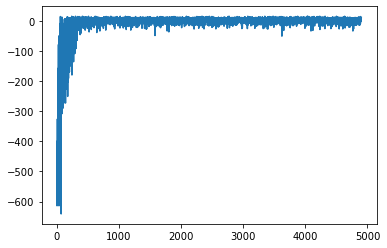

In [155]:
# Проинициализуем агета, создав объект класса
agent = QLearningAgent(alpha=0.5, epsilon=0.1,
                       discount=0.9,
                       get_legal_actions=lambda s: range(
                           n_actions))

assert 'get_policy' in dir(agent)
rewards = []

# Проведем 5к итераций(игр)
for i in range(5000):
    rewards.append(play_and_train(env, agent))  
    # Будем выводить каждые 100
    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon,
              'mean reward =', np.mean(rewards[-10:]))
        print("alpha=", agent.alpha)
        plt.plot(rewards)
        plt.show()

In [156]:
# Сыграем обученным агентом
total_reward = 0.0
s = env.reset()
    
for t in range(1000):
    # выбираем действие
    a = agent.get_action(s)
    next_s, r, done, _ = env.step(a)
        
    s = next_s
    total_reward +=r
    if done:
         break
    
    env.render()
total_reward
# Агент действительно обучился

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


1.0

## DQN

Появляются два новых элемента: **replay buffer и target network**.

#### 1. Replay buffer
Хранит информацию, которую получал агент во время взаимодействия со средой. Позволяет случайно сэмплировать эту информацию в виде кортежей: $<S_{t-1}, a_{t-1}, r_{t-1}, s_{t}, {done}>$.

#### 2. Target Network $Q_{\theta}^{target}$
Используется для вычисления loss функции Policy Net. 
$$L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{\theta}^{target}(s', a')]) ^2.$$
Каждые $N$ шагов обновляется весами $Q_{\theta}$.

#### 3. Policy Net $Q_{\theta}$
Используется для взаимодействия с окружением. Обучается используя накопленный в Replay Buffer опыт.

In [370]:
# импортируем необходимые библиотеки

import gym
import collections
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# если видеокарта доступна, то будем ее использовать
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [381]:
# определяем класс Q-Network

class QNetwork(nn.Module):
    def __init__(self):
        """
        определение сети
        """
        super().__init__()
        
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        """
        определение графа вычислений
        x: вход
        """
        # Линейные преобразования
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def sample_action(self, obs, epsilon):
        """
        сэмплирование действия (е-жадная стратегия)
        """
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 1)
        else:
            return out.argmax().item()

In [422]:
class ReplayBuffer():

    def __init__(self, max_size):
        """
        создаем структуру для хранения данных
        """
        self.buffer = deque([],maxlen=max_size)

    def put(self, transition):
        """
        помещаем данные в replay buffer
        transition: (s, a, r, next_s, done_mask)
        """
        self.buffer.append(transition)

    def sample(self, batch_size):
        """
        сэмплируем батч заданного размера
        batch_size: размер мини-батча
        """
        
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        minibatch = random.sample(self.buffer, batch_size)
        
        for i in range(batch_size):
            s_lst.append(minibatch[i][0])
            a_lst.append(minibatch[i][1])
            r_lst.append(minibatch[i][2])
            s_prime_lst.append(minibatch[i][3])
            done_mask_lst.append(minibatch[i][4])
        
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def __len__(self):
        """
        возвращает размер replay buffer'а
        """
        return len(self.buffer)

In [534]:
def train(q, q_target, replay_buffer, optimizer, batch_size, gamma, updates_number=10):
    """
    функция обучения
    
    q: policy сеть
    q_target: target сеть
    batch_size: размер мини-батча
    gamma: дисконтирующий множитель
    updates_number: количество обновлений (эпох/игр), которые необходимо выполнить
    """
    for i in range(updates_number):
        # сэмплируем мини-батч из replay buffer'а
        s, a, r, s_prime, done_mask = replay_buffer.sample(batch_size)
        print('s', s)
        print('a', a)
        # получаем полезность, для выбранного действия q сети
        q_out = q(s)
        print('q_out', q_out)
        print(q_out.type())
        q_a = q_out.gather(1, torch.tensor([[0,1], [1,1]]))
        print(q_a)

        # получаем значение max_q target сети и считаем значение target
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask

        # определяем loss функцию, для q!
        print('q_a', q_a)
        print('target', target)
        loss = F.smooth_l1_loss(q_a, target.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [535]:
def run(learning_rate, gamma, buffer_max_size, batch_size, target_update_interval,
        replay_buffer_start_size, print_interval=20, n_episodes=2000):
    # создаем окружение для баланса палочки
    env = gym.make('CartPole-v1')

    # создаем q и target_q
    q = QNetwork()
    q_target = QNetwork()

    # копируем веса q в target_q
    q_target.load_state_dict(q.state_dict())

    # создаем replay buffer
    replay_buffer = ReplayBuffer(max_size=buffer_max_size)

    score = 0.0

    # инициализируем оптимизатор, полученным lr
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(n_episodes):

        # постепенно изменяем eps с 8% до 1%
        epsilon = max(0.01, 0.08 - 0.01 * (n_epi / 200))

        s = env.reset()

        # выполянем 600 шагов в окружении и сохраняем, полученные данные
        for t in range(600):

            # получаем действие, используя сеть q
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)

            # выполняем действие в окружении
            s_prime, r, done, info = env.step(a)

            # добавляем данные в replay buffer
            done_mask = 0.0 if done else 1.0
            done_mask = 0
            
            # сжимаем вознаграждения и добавляем в replay buffer
            replay_buffer.put((s, a, r, s_prime, done_mask))

            s = s_prime

            score += r

            if done:
                break

        if len(replay_buffer) > replay_buffer_start_size:
            train(q, q_target, replay_buffer, optimizer, batch_size, gamma)

        if n_epi % target_update_interval == 0 and n_epi != 0:
            q_target.load_state_dict(q.state_dict())

        if n_epi % print_interval == 0 and n_epi != 0:
            print("# of episode :{}, avg score : {:.1f}, buffer size : {}, epsilon : {:.1f}%".format(
                n_epi, score / print_interval, len(replay_buffer), epsilon * 100))
            score = 0.0
    print('Complete')
    env.render()
    env.close()
    plt.ioff()
    plt.show()

In [536]:
# определяем гиперпараметры
run(learning_rate=0.0005,
    gamma=0.98,
    buffer_max_size=50000,
    batch_size=32,
    target_update_interval=10,
    replay_buffer_start_size=2000)

# of episode :20, avg score : 10.4, buffer size : 208, epsilon : 7.9%
# of episode :40, avg score : 10.0, buffer size : 408, epsilon : 7.8%
# of episode :60, avg score : 9.5, buffer size : 598, epsilon : 7.7%
# of episode :80, avg score : 9.8, buffer size : 793, epsilon : 7.6%
# of episode :100, avg score : 9.7, buffer size : 986, epsilon : 7.5%
# of episode :120, avg score : 9.6, buffer size : 1178, epsilon : 7.4%
# of episode :140, avg score : 9.4, buffer size : 1367, epsilon : 7.3%
# of episode :160, avg score : 9.8, buffer size : 1564, epsilon : 7.2%
# of episode :180, avg score : 10.1, buffer size : 1765, epsilon : 7.1%
# of episode :200, avg score : 9.7, buffer size : 1959, epsilon : 7.0%
s tensor([[-1.6869e-02,  2.1642e-03,  1.9299e-03, -1.4817e-02],
        [ 5.7246e-02,  1.3870e+00, -1.1935e-01, -2.0655e+00],
        [ 6.3417e-02,  7.5537e-01, -8.5864e-02, -1.2303e+00],
        [ 3.5204e-03,  3.3562e-02,  2.5634e-02,  6.5838e-03],
        [ 4.8129e-02,  6.1654e-01, -9.1077e-03

C:\Users\4D88~1\AppData\Local\Temp/ipykernel_22364/207840238.py:30: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([2, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(q_a, target.detach())


RuntimeError: The size of tensor a (2) must match the size of tensor b (32) at non-singleton dimension 1